In [1]:
#! conda env create -f environment.yml

### Problem Formulation
The problem is a __supervised text classification problem__, and our goal is to investigate which supervised machine learning methods are best suited to solve it.

Given a new complaint comes in, we want to assign it to one of 12 categories. The classifier makes the assumption that each new complaint is assigned to one and only one category. This is multi-class text classification problem. I can’t wait to see what we can achieve!

Let's start by using the library ```pandas``` to read in the data. ```pandas```is great for data manipulation and analysis - it offers data structures and operations for manipulating tables and time series.

In [2]:
import pandas as pd
df = pd.read_csv('cp.csv', low_memory=False)

### Data Exploration
Before diving into training machine learning models, we should look at some examples first and the number of complaints in each class. Let's take a look at our dataframe, ```df```, by using ```df.head()```to see the top of the file.

In [3]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,10/01/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/05/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760


For this project, we will use two columns — “Product” and “Consumer complaint narrative” - as input to predict an output.

__Input__: Consumer_complaint_narrative

    Example: “ I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements”

__Output__: product

    Example: Credit reporting

In [4]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

Let's remove missing values in ```"Consumer complaints narrative"``` column, and rename ```"Consumer complaints narrative"``` to a  name which doesn't have spaces (this makes it easier to reference later)

In [5]:
original_length = len(df['Consumer complaint narrative'])
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']

print('Number of records removed because they were empty: {}'.format(original_length-len(df)))
print('Remaining records to learn from: {}'.format(len(df)))

Number of records removed because they were empty: 785285
Remaining records to learn from: 311328


Let's add a column encoding the product as an integer because categorical variables are often better represented by integers than strings.

In [6]:
df['category_id'] = df['Product'].factorize()[0]

We will create a couple of dictionaries so that we can understand what the ```category_id``` represents later.

In [7]:
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
print(category_to_id)

{'Credit reporting': 0, 'Consumer Loan': 1, 'Debt collection': 2, 'Mortgage': 3, 'Credit card': 4, 'Other financial service': 5, 'Bank account or service': 6, 'Student loan': 7, 'Money transfers': 8, 'Payday loan': 9, 'Prepaid card': 10, 'Money transfer, virtual currency, or money service': 11, 'Credit reporting, credit repair services, or other personal consumer reports': 12, 'Checking or savings account': 13, 'Vehicle loan or lease': 14, 'Credit card or prepaid card': 15, 'Virtual currency': 16, 'Payday loan, title loan, or personal loan': 17}


In [8]:
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
print(id_to_category)

{0: 'Credit reporting', 1: 'Consumer Loan', 2: 'Debt collection', 3: 'Mortgage', 4: 'Credit card', 5: 'Other financial service', 6: 'Bank account or service', 7: 'Student loan', 8: 'Money transfers', 9: 'Payday loan', 10: 'Prepaid card', 11: 'Money transfer, virtual currency, or money service', 12: 'Credit reporting, credit repair services, or other personal consumer reports', 13: 'Checking or savings account', 14: 'Vehicle loan or lease', 15: 'Credit card or prepaid card', 16: 'Virtual currency', 17: 'Payday loan, title loan, or personal loan'}


In [9]:
df.head()

,Product,Consumer_complaint_narrative,category_id
1,Credit reporting,I have outdated information on my credit repor...,0
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...,1
7,Credit reporting,An account on my credit report has a mistaken ...,0
12,Debt collection,This company refuses to provide me verificatio...,2
16,Debt collection,This complaint is in regards to Square Two Fin...,2


### Imbalanced Classes
We see that the number of complaints per product is imbalanced. Consumers’ complaints are more biased towards Debt collection, Credit reporting and Mortgage.

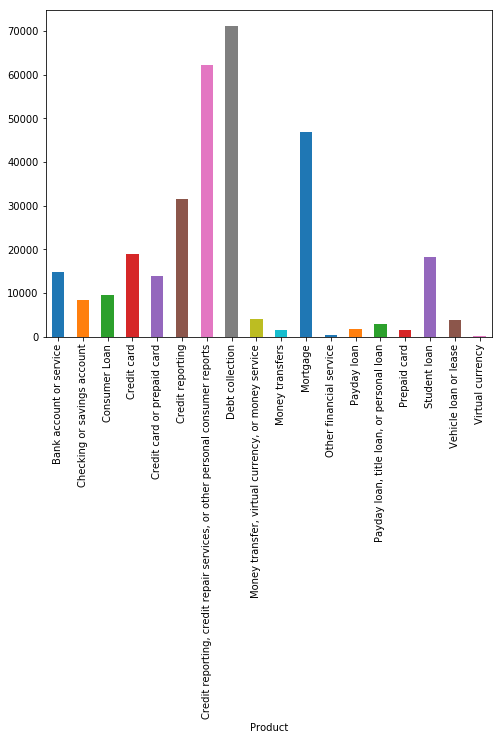

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

When we encounter such problems, we are bound to have difficulties solving them with standard algorithms. Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. In the worst case, minority classes are treated as outliers and ignored. For some cases, such as fraud detection or cancer prediction, we would need to carefully configure our model or artificially balance the dataset, for example by undersampling or oversampling each class.

However, in our case of learning imbalanced data, the majority classes might be of our great interest. It is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy for the minority classes. Therefore, we will leave it as it is.

----

### Text Representation
The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, during the preprocessing step, the texts are converted to a more manageable representation.

Make the dataset smaller because it will require too much memory to create a sparse matrix since we have over 300.000 records.

In [11]:
df_small = df.sample(n=12500, random_state=10)

Distribution looks similar as earlier.

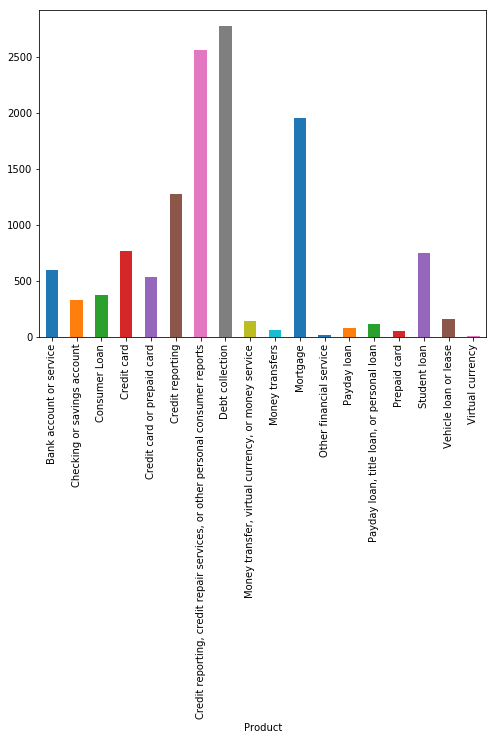

In [12]:
fig = plt.figure(figsize=(8,6))
df_small.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

One common approach for extracting features from text is to use the bag of words model: a model where for each document, a complaint narrative in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

For each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives.

```sublinear_df``` is set to True to use a logarithmic form for frequency.

```min_df``` is the minimum numbers of documents a word must be present in to be kept.

```norm``` is set to l2, to ensure all our feature vectors have a euclidian norm of 1.

```ngram_range``` is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.

```stop_words``` is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2), 
                        stop_words='english')
features = tfidf.fit_transform(df_small.Consumer_complaint_narrative).toarray()

print(features)

[[0.03403787 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01544351 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.07949036 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [14]:
labels = df_small.category_id
features.shape

(12500, 33878)

Let's find the terms that are the most correlated with each of the products:

In [15]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    print("\n---------------------\n")
    print("'{}':".format(Product))
    print("  - Most correlated unigrams:\n    * {}".format('\n    * '.join(unigrams[-N:])))
    print("  - Most correlated bigrams:\n    * {}".format('\n    * '.join(bigrams[-N:])))


---------------------

'Bank account or service':
  - Most correlated unigrams:
    * bank
    * overdraft
  - Most correlated bigrams:
    * overdraft fees
    * checking account

---------------------

'Checking or savings account':
  - Most correlated unigrams:
    * overdraft
    * checking
  - Most correlated bigrams:
    * overdraft fees
    * checking account

---------------------

'Consumer Loan':
  - Most correlated unigrams:
    * ally
    * vehicle
  - Most correlated bigrams:
    * auto loan
    * ally financial

---------------------

'Credit card':
  - Most correlated unigrams:
    * macy
    * card
  - Most correlated bigrams:
    * american express
    * credit card

---------------------

'Credit card or prepaid card':
  - Most correlated unigrams:
    * merchant
    * card
  - Most correlated bigrams:
    * gift card
    * credit card

---------------------

'Credit reporting':
  - Most correlated unigrams:
    * equifax
    * experian
  - Most correlated bigrams:
 

What do you think? Do these make sense?

After having vector representations of the text we can train supervised classifiers to train unseen “Consumer complaint narrative” and predict the “product” on which they fall.

### Preliminary Model Testing using Naive Bayes

After this data transformation, it is time to train the classifiers. There are a number of algorithms we can use for this type of problem. We will first test Naive Bayes and see how well it predicts entries it hasn't seen before.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df_small['Consumer_complaint_narrative'], 
                                                    df_small['Product'], 
                                                    random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

Let's test it by using entries in the original data frame but not in the dataframe used for training.

In [17]:
df_validate = df[~df.index.isin(df_small.index)]

Test different entries by changing the value of ```i```. This will select an entry using location indexing in the next line.

In [18]:
i = 60
s_test = df_validate.Consumer_complaint_narrative.iloc[i]
print(s_test)

Quicken loan and fraudulent claims to get you to refinance with them. This is a VA loan, my husband served his country for 20 years to be taken advantage of and lied to so someone could make a few dollars. The lending agent from Quicken loans specifically told us our payments would be applied to our loan every two weeks as paid and not held in suspense. Once the loan was cleared we became aware of the fact that the funds that are automatically taken out of our account were indeed held in suspense until the full monthly payment is collected, plus an extra XXXX a month and then all of the funds are held until the date the payment is due. The loan we had previously was done the same way and we were emphatic about my payments being applied every two weeks. The end result is we paid XXXX in closing fees to get exactly the same thing I had before. They are auto deducting my payments every 14 days and holding them until the until the due date so we are not getting credit on the interest for p

In [19]:
print(clf.predict(count_vect.transform([s_test])))

['Mortgage']


In [20]:
print(df_validate.Product.iloc[i])

Mortgage


If you get a predicted label which is different from actual label, why do you think that is? What could you do to improve this?

### Model Testing

We will benchmark the following four models:

- Logistic Regression
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    print('Running: {}'.format(model_name))
    
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Running: RandomForestClassifier


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Running: LinearSVC


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Running: MultinomialNB


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Running: LogisticRegression


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


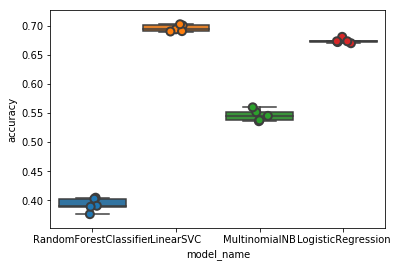

In [28]:
import seaborn as sns
sns.boxplot(x='model_name', 
            y='accuracy', 
            data=cv_df)
sns.stripplot(x='model_name', 
              y='accuracy', 
              data=cv_df, 
              size=8, 
              jitter=True, 
              edgecolor="gray", 
              linewidth=2)
plt.show()

In [23]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.695758
LogisticRegression        0.674074
MultinomialNB             0.546092
RandomForestClassifier    0.392647
Name: accuracy, dtype: float64

### Model Evaluation
We will continue with our best model (LinearSVC) and look at the confusion matrix. This shows the discrepancies between predicted and actual labels.

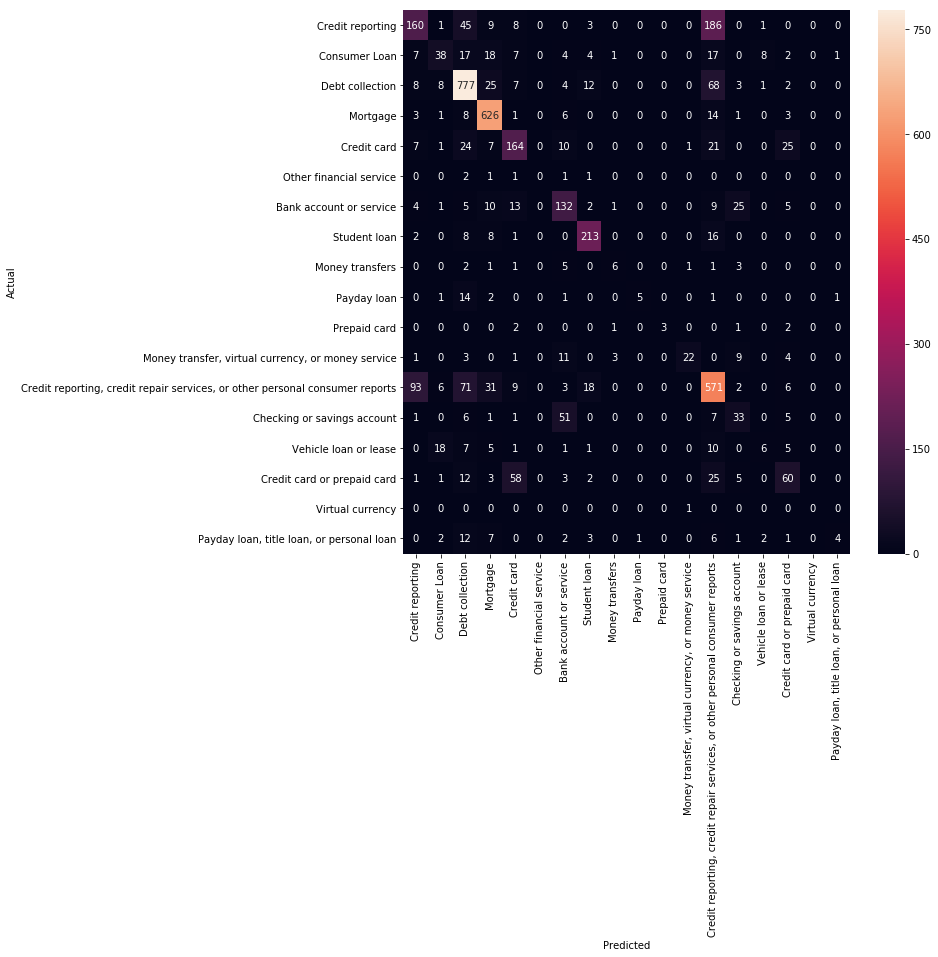

In [24]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, 
                                                                                 labels, 
                                                                                 df_small.index, 
                                                                                 test_size=0.33, 
                                                                                 random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, 
            annot=True, 
            fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be. However, there are a number of misclassifications, and it might be interesting to see what those are caused by:

In [25]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                                 id_to_category[predicted], 
                                                                 conf_mat[actual, predicted]))
            display(df_small.loc[indices_test[(y_test == actual) & 
                                            (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
            print('')

'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 93 examples.


,Product,Consumer_complaint_narrative
953903,"Credit reporting, credit repair services, or o...",XXXX XXXX retail had pulled an inquiry on XXXX...
619487,"Credit reporting, credit repair services, or o...",ID THEFT! The account listed on my credit repo...
835524,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX all free annual credit reports w...
909383,"Credit reporting, credit repair services, or o...",I checked my information\non equifax2017securi...
1082054,"Credit reporting, credit repair services, or o...",I have two derogatory marks on my Equifax repo...
889955,"Credit reporting, credit repair services, or o...",I did not ask for a security freeze to be put ...
262911,"Credit reporting, credit repair services, or o...",I have sent all 3 major credit companies dispu...
876286,"Credit reporting, credit repair services, or o...",I submitted a reinvestigation dispute for 2 ac...
984734,"Credit reporting, credit repair services, or o...",Hi! \n\nI applied for a new apartment building...
1086364,"Credit reporting, credit repair services, or o...",Trans Union and XXXX have not removed a report...



'Vehicle loan or lease' predicted as 'Consumer Loan' : 18 examples.


,Product,Consumer_complaint_narrative
269628,Vehicle loan or lease,I have a vehicle financed w ith Prestige Finan...
923888,Vehicle loan or lease,My lease was up in XX/XX/XXXX. I extended my l...
1077681,Vehicle loan or lease,I BECOME AWARE THAT CAPITAL ONE AUTO FINANCE R...
835736,Vehicle loan or lease,"In XXXX 2015, I an d m y Father refin ance ..."
861085,Vehicle loan or lease,American Honda Finance is reporting a recent l...
944854,Vehicle loan or lease,"Car dealer in XXXX created predatory loan, acc..."
867505,Vehicle loan or lease,ALLY bank does not include outstanding loan ba...
795216,Vehicle loan or lease,I did contact Compass Bank to inquire about ho...
1018157,Vehicle loan or lease,I took out a loan with US Bank in XX/XX/XXXX. ...
972553,Vehicle loan or lease,"On XXXX/XXXX/XXXX, I purchased a XXXX XXXX XXX..."



'Credit reporting' predicted as 'Debt collection' : 45 examples.


,Product,Consumer_complaint_narrative
118324,Credit reporting,TRANUNION today has verified either knowingly ...
482473,Credit reporting,HSBC has a derogatory account listed on my cre...
46473,Credit reporting,I have a debt on my credit report with XXXX XX...
29358,Credit reporting,XXXX XXXX XXXX must be removed from report. I ...
475177,Credit reporting,Case numbers : XXXX need to know why my credit...
309439,Credit reporting,Please remove XXXX from my collection and any ...
615025,Credit reporting,I had contacted equifax to remove a account fr...
444049,Credit reporting,Transunion received a complaint and dispute fr...
238999,Credit reporting,XXXX account # XXXX I paid for 1 month of serv...
206536,Credit reporting,Had XXXX XXXX XXXX for approximately 15 years ...



'Consumer Loan' predicted as 'Debt collection' : 17 examples.


,Product,Consumer_complaint_narrative
143872,Consumer Loan,"I have a car loan through XXXX, which I believ..."
776713,Consumer Loan,TJX TJMAX said that I have an account and I to...
360877,Consumer Loan,PURCHASED MATTRESS AND WAS NOT TOLD ABOUT PROM...
759596,Consumer Loan,The scammers are using at least XXXX different...
624046,Consumer Loan,"To whom it may concern, This is my second comp..."
291450,Consumer Loan,I am a XXXX XXXX XXXX woman and did not unders...
294230,Consumer Loan,"XX/XX/XXXX, I purchased a XXXX Dodge Intrepid...."
403873,Consumer Loan,I set up a automatic payment with west lake fi...
418755,Consumer Loan,XXXX XXXX bought a business debt from a compan...
418786,Consumer Loan,"This is with Credit Central of XXXX Alabama, f..."



'Credit card' predicted as 'Debt collection' : 24 examples.


,Product,Consumer_complaint_narrative
933980,Credit card,Eleven years ago I lost my job then had a prob...
130892,Credit card,Chase Bank is reporting a negative charge off ...
371001,Credit card,A Paypal credit account was opened in my name ...
517954,Credit card,"Citi calls me a minimum of three times a day, ..."
112142,Credit card,Requested increase in credit limit. The limits...
231666,Credit card,I opened a Discover Credit card to re-establis...
773602,Credit card,I have recently went to work for the XXXX and ...
128712,Credit card,Ca n't reset password and pay online. Tried to...
520429,Credit card,"A Florida company named "" XXXX '' obtained inf..."
173823,Credit card,Macy 's somehow got my XXXX year old Mother 's...



'Payday loan' predicted as 'Debt collection' : 14 examples.


,Product,Consumer_complaint_narrative
45629,Payday loan,"HARASSING PHONE CALLS ON MY CELL NUMBER, THREA..."
146224,Payday loan,I have paid for a pay day loan XXXX and now am...
206262,Payday loan,"I borrowed {$400.00} in XXXX XXXX, I was told ..."
306904,Payday loan,I was lay off from my job on XX/XX/2014 making...
685993,Payday loan,I filed a complaint to the XXXX Dept of Justic...
669098,Payday loan,Nearly seven years ago I received a collection...
679310,Payday loan,I received an email stating that I owed money ...
171095,Payday loan,I was refused a PayDay loan because they have ...
133440,Payday loan,"XXXX XXXX, XXXX XXXXTook out a payday loan wit..."
521129,Payday loan,This loan is illegal in the state. They have t...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 71 examples.


,Product,Consumer_complaint_narrative
803285,"Credit reporting, credit repair services, or o...",I receive daily multiple calls from this compa...
823202,"Credit reporting, credit repair services, or o...","This should go to a Supervisor, not just custo..."
886813,"Credit reporting, credit repair services, or o...",I was part of the Midland Credit Management TC...
925047,"Credit reporting, credit repair services, or o...","Dear CFPB, Target / TD bank has been reporting..."
1078189,"Credit reporting, credit repair services, or o...",I have disputed these accounts from XXXX/XXXX ...
836971,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX is attempting to collect ...
851661,"Credit reporting, credit repair services, or o...",I submitted proof that the debt in question wa...
806550,"Credit reporting, credit repair services, or o...","My information includes a false "" also known a..."
878476,"Credit reporting, credit repair services, or o...",Syndicated office keeps reporting accounts on ...
1088806,"Credit reporting, credit repair services, or o...","For about 6 months, I have been disputing an c..."



'Credit card or prepaid card' predicted as 'Debt collection' : 12 examples.


,Product,Consumer_complaint_narrative
1078460,Credit card or prepaid card,my husband was involved in a XXXX XXXX collisi...
946159,Credit card or prepaid card,Company : American Express Card : SPG Problem ...
819000,Credit card or prepaid card,Last year I called Bank of America for two o...
814768,Credit card or prepaid card,I filed an return protection claim for an exte...
997597,Credit card or prepaid card,From what I remember correctly was XXXX XXXX w...
1022606,Credit card or prepaid card,I called XXXX for a car to pick me up at a par...
868569,Credit card or prepaid card,I have been a Best Buy Credit Card Account mem...
886455,Credit card or prepaid card,I stop using the two credit cards from Discove...
1014831,Credit card or prepaid card,I spoke with an account rep who was not a mana...
816944,Credit card or prepaid card,"On XX/XX/XXXX, I opened an account with Capita..."



'Payday loan, title loan, or personal loan' predicted as 'Debt collection' : 12 examples.


,Product,Consumer_complaint_narrative
949436,"Payday loan, title loan, or personal loan",I am trying to get detailed information regard...
950745,"Payday loan, title loan, or personal loan",I sent correspondence to the company on XX/XX/...
1062420,"Payday loan, title loan, or personal loan",For awhile now I have been borrowing from a co...
917482,"Payday loan, title loan, or personal loan",The company states that I have n't payed them ...
1053641,"Payday loan, title loan, or personal loan",Last year approximately XX/XX/XXXX I paid Mari...
880557,"Payday loan, title loan, or personal loan","Mariner Finance, f/k/a Personal Finance Compan..."
991984,"Payday loan, title loan, or personal loan",They call my mother every day for the past 2 w...
1036265,"Payday loan, title loan, or personal loan",I moved and when I moved I closed the account ...
828208,"Payday loan, title loan, or personal loan",I received a phone call 3 years ago stating I ...
1084722,"Payday loan, title loan, or personal loan",the company missed my private information and ...



'Consumer Loan' predicted as 'Mortgage' : 18 examples.


,Product,Consumer_complaint_narrative
293028,Consumer Loan,I have a loan from Prosper. This was contractu...
616160,Consumer Loan,"I had a loan with Monterey Financial Services,..."
596888,Consumer Loan,I have not received a loan statement from VW C...
466297,Consumer Loan,I received an automobile loan from Wachovia Ba...
316142,Consumer Loan,"I have been sending "" overage '' payments abov..."
776502,Consumer Loan,I traded my XXXX XXXX XXXX for a XXXX XXXX at ...
170503,Consumer Loan,I wanted to pay off my lease. So I went to the...
605023,Consumer Loan,On XXXX/XXXX/XXXX I applied for a loan with Ch...
376505,Consumer Loan,I took out a flex loan XX/XX/2016 shortly afte...
140612,Consumer Loan,In 2007 I took out an equity loan with Bank of...



'Debt collection' predicted as 'Mortgage' : 25 examples.


,Product,Consumer_complaint_narrative
990067,Debt collection,"McCarthy & Holthus is allowing "" Abusive Colle..."
1096101,Debt collection,home owner association said i had an {$8000.00...
422806,Debt collection,I XXXX contacting you concerning an account Ch...
721035,Debt collection,Nationstar is reporting false and misrepresent...
970610,Debt collection,"XXXX XXXX XXXX XXXX VIOLATED A COURT ORDER, TR..."
1065947,Debt collection,"Please find that "" XXXX XXXX XXXX '' is acting..."
545650,Debt collection,Ocwen loan servicing LLC has violated ALL rule...
148062,Debt collection,I have several medical bills that I am trying ...
625665,Debt collection,Please refer to my previous complaint case num...
995305,Debt collection,Response from SETERUS to complaint number XXXX...



'Bank account or service' predicted as 'Mortgage' : 10 examples.


,Product,Consumer_complaint_narrative
111507,Bank account or service,Hello I am following-up on my earlier complain...
252248,Bank account or service,This is reference the Wells Fargo Scandal of X...
490244,Bank account or service,PAYPAL does not accept my XXXX XXXX XXXX [ iss...
789561,Bank account or service,Applied for loan for hot tub purchase from Wel...
660754,Bank account or service,I have a checking account and a loan ( previou...
546537,Bank account or service,A bank fraudently claimed ownership of land th...
671407,Bank account or service,Essentially this is NOT my XXXX complaint abou...
312264,Bank account or service,Your Home Page is emblazoned with WE 'RE ON YO...
515930,Bank account or service,I email chase and ask them to explain why my p...
450835,Bank account or service,I have spoken to 3 employees of Associated Ban...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Mortgage' : 31 examples.


,Product,Consumer_complaint_narrative
903362,"Credit reporting, credit repair services, or o...",Starting around XX/XX/XXXX I entered into a lo...
1092880,"Credit reporting, credit repair services, or o...",Never applyed for a refinance loan with any of...
906403,"Credit reporting, credit repair services, or o...","In XX/XX/XXXX, I applied for a loan through XX..."
1068812,"Credit reporting, credit repair services, or o...","In order to prevent any deception, misrepresen..."
794940,"Credit reporting, credit repair services, or o...",I understand that the law is civil judgments a...
268884,"Credit reporting, credit repair services, or o...",In XXXX of XXXX I missed a payment with ...
1003151,"Credit reporting, credit repair services, or o...",I have a loan that was on Identity Theft & fra...
859215,"Credit reporting, credit repair services, or o...",I was in the process of refinancing my house a...
823277,"Credit reporting, credit repair services, or o...",My wife and I sold our home in XXXX and clos...
871803,"Credit reporting, credit repair services, or o...","First off, my mortgage company said that I owe..."



'Bank account or service' predicted as 'Credit card' : 13 examples.


,Product,Consumer_complaint_narrative
296869,Bank account or service,On XXXX XXXX I applied for a high yield saving...
6801,Bank account or service,Capital One Bank Reversed my dispute 3 times a...
772078,Bank account or service,some bank credit cards have very complex incom...
594203,Bank account or service,A payment was sent to Bank of America without ...
437607,Bank account or service,I attempted to open a saving account with Capi...
183510,Bank account or service,Chase charged {$5000.00} in unneeded overdraft...
245579,Bank account or service,"XXXX XXXX, XX/XX/2015Dear CFPB, I use the HSBC..."
478383,Bank account or service,"Wells Fargo signed me up for their "" Go Farthe..."
551499,Bank account or service,"XXXX XXXX, 2016 On XXXX XXXX, 2016 I met with ..."
291239,Bank account or service,"XXXX/XXXX/XXXX I purchased XXXX XXXX "" XXXX ''..."



'Credit card or prepaid card' predicted as 'Credit card' : 58 examples.


,Product,Consumer_complaint_narrative
864645,Credit card or prepaid card,SOMEONE USED MY IDENTIFICATION TO OPEN A FRAUD...
1024116,Credit card or prepaid card,On XX/XX/2018 : Received paper bill From XXXX ...
991443,Credit card or prepaid card,I got a secured credit card with USAA a year a...
867657,Credit card or prepaid card,"on XX/XX/2017, I was XXXX at XXXX XXXX. XXXX X..."
950366,Credit card or prepaid card,Having had a credit card for some years with A...
965323,Credit card or prepaid card,I am writing to complain against HSBC Bank USA...
1076379,Credit card or prepaid card,"I opened a Citibank credit card in XXXX, and a..."
974562,Credit card or prepaid card,In XX/XX/XXXX we received a call from Citibank...
941157,Credit card or prepaid card,i have never missed a payment on gas card or m...
990275,Credit card or prepaid card,Key Bank took over my XXXX XXXX account and cu...



'Credit card' predicted as 'Bank account or service' : 10 examples.


,Product,Consumer_complaint_narrative
769035,Credit card,on XXXX XXXX 2016 I sent citi aadvatage platin...
645045,Credit card,I had a judgment against me in XX/XX/XXXX with...
436218,Credit card,"I was enrolled, with out my consent, into "" CI..."
47554,Credit card,Bank of America allowed a credit card account ...
664443,Credit card,Often the programming within the bank 's websi...
675458,Credit card,I had a secured credit card with Wells Fargo. ...
605789,Credit card,I received a TD Bank Privacy Policy Disclosure...
526364,Credit card,We were offered 0 % interest convenience check...
674103,Credit card,"While in XXXX, someone gained access to my deb..."
410373,Credit card,I took out what was called The Gold Option Loa...



'Money transfer, virtual currency, or money service' predicted as 'Bank account or service' : 11 examples.


,Product,Consumer_complaint_narrative
842926,"Money transfer, virtual currency, or money ser...","On this date, XX/XX/17, I called the XXXX bran..."
989145,"Money transfer, virtual currency, or money ser...","On XXXX XXXX, I saw a notification that on XXX..."
844809,"Money transfer, virtual currency, or money ser...",This is a problem with my paypal account. They...
1005379,"Money transfer, virtual currency, or money ser...",On XX/XX/2018 at approximately XXXX I received...
972950,"Money transfer, virtual currency, or money ser...",The company attempted to make an unauthorized ...
970670,"Money transfer, virtual currency, or money ser...",In the past I have sent money a couple of time...
1015635,"Money transfer, virtual currency, or money ser...",Amount of {$3400.00} was wire transferred out ...
1062150,"Money transfer, virtual currency, or money ser...",Date XX/XX/XXXX Complaint against XXXX and Cit...
1091018,"Money transfer, virtual currency, or money ser...",On XX/XX/XXXX I received an email about a job ...
258022,"Money transfer, virtual currency, or money ser...",On XXXX / XXXX / XXXX at XXXX XXXX our...



'Checking or savings account' predicted as 'Bank account or service' : 51 examples.


,Product,Consumer_complaint_narrative
849267,Checking or savings account,First the Facts : XX/XX/XXXX - I noted and una...
879733,Checking or savings account,"On 2017XXXXXX, my checking account was overdra..."
894350,Checking or savings account,Chase claims they do a courtesy one time no ov...
1011451,Checking or savings account,THIS IS A CONSISTENT PROBLEM THAT I 'M CONTINU...
1069332,Checking or savings account,I received my paycheck from XXXX XXXX ( XXXX X...
812297,Checking or savings account,Originally Bank of America stated they closed...
279331,Checking or savings account,I opened an account with a coupon that I would...
793634,Checking or savings account,I was being charged {$25.00} from what I belie...
131167,Checking or savings account,"Around XX/XX/XXXX, I reopened my USAA checking..."
950940,Checking or savings account,On XXXX/XXXX/XXXX I deposited a check for {$15...



'Debt collection' predicted as 'Student loan' : 12 examples.


,Product,Consumer_complaint_narrative
965228,Debt collection,"On XXXX XXXX, 2017, I received a letter from X..."
1029517,Debt collection,I received an email in XX/XX/2018 that my stud...
789112,Debt collection,They continue to report that my loans are deli...
610701,Debt collection,"On Monday, XXXX XXXX, 2015, My next door neigh..."
830537,Debt collection,"This is in response to a prior complaint, numb..."
794298,Debt collection,Graduated from XXXX XXXX XX/XX/XXXX. \nReceive...
215479,Debt collection,I paid off a student loan in full on XXXX 2016...
62531,Debt collection,I have a student loan consolidation in progres...
372867,Debt collection,"On XXXX XXXX, XXXX, I agreed to a settlement t..."
160989,Debt collection,I received a letter and multiple collection ag...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Student loan' : 18 examples.


,Product,Consumer_complaint_narrative
1004952,"Credit reporting, credit repair services, or o...",I have several student loans with Nelnet per m...
800832,"Credit reporting, credit repair services, or o...","On XX/XX/XXXX, I graduated from the University..."
1055529,"Credit reporting, credit repair services, or o...",I have had my student loans through XXXX XXXX ...
1082881,"Credit reporting, credit repair services, or o...",There is a private student loan issued by XXXX...
1081572,"Credit reporting, credit repair services, or o...",The balance that is shown from my charged off ...
999584,"Credit reporting, credit repair services, or o...","XXXX XXXX, Navient, XXXX and XXXX reporting lo..."
1089394,"Credit reporting, credit repair services, or o...",I am writing this letter in regards to my acco...
806387,"Credit reporting, credit repair services, or o...",I was not notified that my student loans were ...
1055646,"Credit reporting, credit repair services, or o...",I received a discharge on X/XX/2009 for total ...
257872,"Credit reporting, credit repair services, or o...",I have submitted this claim prior but their re...



'Credit reporting' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 186 examples.


,Product,Consumer_complaint_narrative
37275,Credit reporting,I filed a dispute and a request for a Bankrupt...
385549,Credit reporting,I disputed a Collection with Transunion. XXXX ...
664639,Credit reporting,"XX/XX/XXXX, I was coming from campus at the un..."
551258,Credit reporting,"MCA Mangement CO, is reporting a debt that is ..."
335804,Credit reporting,I originally had XXXX school loans with XXXX t...
579476,Credit reporting,"On XX/XX/XXXX, I discovered an account that ha..."
193487,Credit reporting,Equifax will not correct errors that they plac...
288829,Credit reporting,acct # XXXX XXXX XXXX was never late all other...
334831,Credit reporting,This credit reporting bureau is reporting inco...
666264,Credit reporting,I have inquires on my credit report that do no...



'Consumer Loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 17 examples.


,Product,Consumer_complaint_narrative
365916,Consumer Loan,There a couple or several inquiries being repo...
229268,Consumer Loan,I am writing because I am very concerned about...
785601,Consumer Loan,I disputed an account with Chase Auto Finance ...
312433,Consumer Loan,Consumer Portfolio Services reported the incor...
727571,Consumer Loan,Jaguar Credit is listing inaccurate informatio...
461147,Consumer Loan,I had an autoloan with BB & T Bank that was pa...
198943,Consumer Loan,Mercedes Financial has been reporting incorrec...
401547,Consumer Loan,I have an installment loan with Lendmark Finan...
776725,Consumer Loan,I experienced identity theft and notified XXXX...
554904,Consumer Loan,Lender reported to credit bureaus that my XXXX...



'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 68 examples.


,Product,Consumer_complaint_narrative
871357,Debt collection,"This was a bill with XXXX XXXX XXXX, when I sh..."
439966,Debt collection,I have no knowledge of this debt. My account w...
854646,Debt collection,I have submitted in a complaint before and hav...
942045,Debt collection,I have contacted the court house in my state i...
829882,Debt collection,ERC is fraudulently reporting my credit inform...
780349,Debt collection,"XXXX XXXX 2014, I initiated disputes XXXX rega..."
1008639,Debt collection,I 've back and forth with these credit reporti...
370233,Debt collection,ALLIED INTERSTATE LLC COLLECTION AGENCY REPORT...
735397,Debt collection,I had a car loan on a XXXX XXXX in XXXX from C...
83031,Debt collection,I received 3 letters from XXXX Credit monitor...



'Mortgage' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 14 examples.


,Product,Consumer_complaint_narrative
708696,Mortgage,"On or about XXXX, I was made aware, from my cr..."
133716,Mortgage,I had my credit report ran from my preferred l...
394203,Mortgage,We make our payments on the 1st of every month...
279271,Mortgage,After having an account with Ocwen for XXXX...
427918,Mortgage,"I SHORT SALE MY HOUSE IN XXXX OF 2010, WITH CH..."
762933,Mortgage,This loan was discharged and paid off in a Cha...
118255,Mortgage,I want to add this Motion of information I fil...
1023908,Mortgage,While XXXX XXXX from Carrington Mortgage Servi...
753306,Mortgage,I did an authorized short-sale XX/XX/XXXX with...
233121,Mortgage,We applied Home Equity Line of Credit with US ...



'Credit card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 21 examples.


,Product,Consumer_complaint_narrative
115834,Credit card,American Express is reporting an account on my...
632036,Credit card,Bank of America is falsely reporting to credit...
357100,Credit card,This company is reporting an outstanding debt ...
773252,Credit card,Tried getting a credit line increase on my Bar...
615410,Credit card,As part of a divorce settlement my wife assume...
298722,Credit card,While using a company called XXXX XXXX to moni...
1490,Credit card,Capital One violated the FCRA 623 ( a ) Duty t...
694384,Credit card,I had a Chase card account that was CLOSED and...
789747,Credit card,"XXXX XXXX XXXX XXXX XXXX XXXX, New Jersey XXXX..."
116783,Credit card,"On X/XX/17 , I went to XXXX XXXX to p..."



'Student loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 16 examples.


,Product,Consumer_complaint_narrative
498829,Student loan,I was shocked when I reviewed my credit report...
1085238,Student loan,I am submitting my complaint formally to resol...
29666,Student loan,They are reporting the same account on the cre...
959348,Student loan,All Details Are In Submitted Documents Overvie...
847890,Student loan,I am requesting all three of my credit files b...
47251,Student loan,I have XXXX student loans in TPD at NelNet und...
1083863,Student loan,Falsely created account and false amount owed ...
963191,Student loan,I 've contacted the Dept. of Education/Navient...
14917,Student loan,They have called multiple times at my job that...
74236,Student loan,XX/XX/XXXXUNIVERSITY ACCOUNTING SERVICES & XXX...



'Vehicle loan or lease' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 10 examples.


,Product,Consumer_complaint_narrative
1031416,Vehicle loan or lease,Auto Dealer Fraud. Buying a car can be a fun a...
1042195,Vehicle loan or lease,XXXX XXXX opened up a unwanted credit card wit...
1079481,Vehicle loan or lease,I purchased a car from XXXX XXXX XXXX. I had f...
972042,Vehicle loan or lease,"on XXXX XXXX, XXXX I faxed CHRYSLER CAPITAL as..."
1004972,Vehicle loan or lease,On XX/XX/XXXX I purchase an vehicle from XXXX ...
944801,Vehicle loan or lease,Santander was charged off and settled in XXXX....
850688,Vehicle loan or lease,I purchased a XXXX XXXX XXXX on XX/XX/2017 fro...
979928,Vehicle loan or lease,On XX/XX/XXXX I rec 'd a letter from XXXX XXXX...
282939,Vehicle loan or lease,I have an open account with a company that I c...
869302,Vehicle loan or lease,I purchased a XXXX XXXX XXXX with my brother (...



'Credit card or prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 25 examples.


,Product,Consumer_complaint_narrative
804778,Credit card or prepaid card,Citicards refuses to delete unverified and ina...
953694,Credit card or prepaid card,regarding my recent late payments in relation ...
1006727,Credit card or prepaid card,XXXX XXXX XXXXCardmember services (see attachm...
1076250,Credit card or prepaid card,"XXXX XXXX denied my application for their "" XX..."
894862,Credit card or prepaid card,I have had a Paypal account through XXXX XXXX ...
907691,Credit card or prepaid card,I was a victim of Identity Theft and only lear...
851721,Credit card or prepaid card,National data breaches compromised my credit. ...
936147,Credit card or prepaid card,Complaint # 1 re dispute of charges on Chase S...
974072,Credit card or prepaid card,I have had numerous accounts with Conn 's in X...
1024187,Credit card or prepaid card,THE COMPANY’S RESPONSE ADDRESSED ALL OF MY ISS...



'Bank account or service' predicted as 'Checking or savings account' : 25 examples.


,Product,Consumer_complaint_narrative
1209,Bank account or service,XX/XX/XXXX I received a confirmation of addres...
229380,Bank account or service,My M & T checking account was overdrawn by {$3...
116578,Bank account or service,Bank accounts ( CD & Money Markets ) w as ope...
331539,Bank account or service,I opened an account with Citizens Bank XX/XX/X...
474699,Bank account or service,We purchased a purse from a business that desc...
614328,Bank account or service,Chase bank charged an unauthorized {$70.00} ag...
432894,Bank account or service,"several slandering, tricks, and false informat..."
10957,Bank account or service,I came thru drive thru at XXXX to drop off XXX...
44445,Bank account or service,When I used the ATM at the Bank of America XXX...
48576,Bank account or service,My husband and I have multiple bank accounts w...



'Credit card' predicted as 'Credit card or prepaid card' : 25 examples.


,Product,Consumer_complaint_narrative
541369,Credit card,"On XX/XX/2016, I applied for and was approved ..."
707337,Credit card,My closing agent mailed XXXX checks to payoff ...
744958,Credit card,"XXXX XXXX, XXXX Synchrony Bank Payment Researc..."
455172,Credit card,I disputed a charge on my Citibank Visa for an...
933141,Credit card,Barclay card is asking for a high minimum paym...
396226,Credit card,Wells Fargo that has a history of cheating peo...
518511,Credit card,I went XXXX merchant XXXX request a cost estim...
469407,Credit card,I had a promotional APR of 0 % for 18 months o...
215303,Credit card,this is my favorite bank with favorite card bu...
177723,Credit card,XX/XX/XXXX I applied for a Wal-Mart Credit Car...


As you can see, some of the misclassified complaints are complaints that touch on more than one subjects (for example, complaints involving both credit card and credit report). These sorts of errors are common. What would you do to improve that?

Let's find the terms that are the most correlated with each of the categories:

In [26]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("\n---------------------\n")
    print("'{}':".format(Product))
    print("  - Most correlated unigrams:\n    * {}".format('\n    * '.join(unigrams[-N:])))
    print("  - Most correlated bigrams:\n    * {}".format('\n    * '.join(bigrams[-N:])))


---------------------

'Bank account or service':
  - Most correlated unigrams:
    * bank
    * debit
  - Most correlated bigrams:
    * direct express
    * bank card

---------------------

'Checking or savings account':
  - Most correlated unigrams:
    * bank
    * blocking
  - Most correlated bigrams:
    * fee charge
    * atm card

---------------------

'Consumer Loan':
  - Most correlated unigrams:
    * ally
    * vehicle
  - Most correlated bigrams:
    * discover credit
    * car payments

---------------------

'Credit card':
  - Most correlated unigrams:
    * card
    * macy
  - Most correlated bigrams:
    * credit card
    * xx 2016

---------------------

'Credit card or prepaid card':
  - Most correlated unigrams:
    * card
    * gift
  - Most correlated bigrams:
    * xxxx 2017
    * promotional balance

---------------------

'Credit reporting':
  - Most correlated unigrams:
    * experian
    * equifax
  - Most correlated bigrams:
    * xxxx bank
    * bureaus 

Are these consistent with what we expect?

------
#### Compute precision, recall, F-measure and support for each class

The __precision__ is the ratio ```tp / (tp + fp)``` where ```tp``` is the number of true positives and ```fp``` the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The __recall__ is the ratio ```tp / (tp + fn)``` where ```tp``` is the number of true positives and ```fn``` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The __F-beta score__ can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of ```beta```. ```beta == 1.0``` means recall and precision are equally important.

The support is the number of occurrences of each class in ```y_true```.

In [27]:
from sklearn import metrics
print(metrics.classification_report(y_test, 
                                    y_pred, 
                                    target_names=df_small['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                                Student loan       0.56      0.39      0.46       413
Credit reporting, credit repair services, or other personal consumer reports       0.49      0.31      0.38       124
                                                             Debt collection       0.77      0.85      0.81       915
                                                 Checking or savings account       0.83      0.94      0.88       663
                                                            Credit reporting       0.60      0.63      0.61       260
                                                                    Mortgage       0.00      0.00      0.00         6
                                   Payday loan, title loan, or personal loan       0.56      0.64      0.60       207
                                                 Credit

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Are you happy with these results? 

How would you go about building a better model? Things to consider: 
- Number of reports we had to learn from
- Imbalanced classes
- Pre-processing the data
- What do you know about the dataset? Who has labeled them?